In [110]:
import numpy as np
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='whitegrid', color_codes=True)
mpl.rcParams['figure.figsize'] = (12,6)

In [111]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[0,1,9,10,14]]
          .loc[~df['v_siII'].isnull(), :]
         )
    df['v_siII'] = df['v'] * df['v_siII']
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,SN_Host,v,v_siII,vi_siII_err,SN_type
SN,,,,,
1998de,NGC252,4619,5219.47,2.0,Iabg
1998dk,UGC139,3609,4583.43,3.0,IaH
1998ef,UGC646,5019,6675.27,2.0,IaH
1998es,NGC632,2868,3384.24,2.0,IaT
1999aa,NGC2595,4572,4754.88,2.0,IaT


<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 1998de to 2008hv
Data columns (total 5 columns):
SN_Host        165 non-null object
v              165 non-null int64
v_siII         165 non-null float64
vi_siII_err    162 non-null float64
SN_type        157 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 7.7+ KB


None

,v,v_siII,vi_siII_err
count,165.000000,165.000000,162.000000
mean,6467.975758,7866.930667,3.563951
std,2946.705128,4571.613595,2.069367
min,841.000000,849.410000,0.000000
25%,4418.000000,4620.000000,2.000000
50%,6255.000000,7700.700000,3.000000
75%,8692.000000,10132.640000,5.000000
max,14732.000000,31749.000000,10.000000


http://mathworld.wolfram.com/SpherePointPicking.html

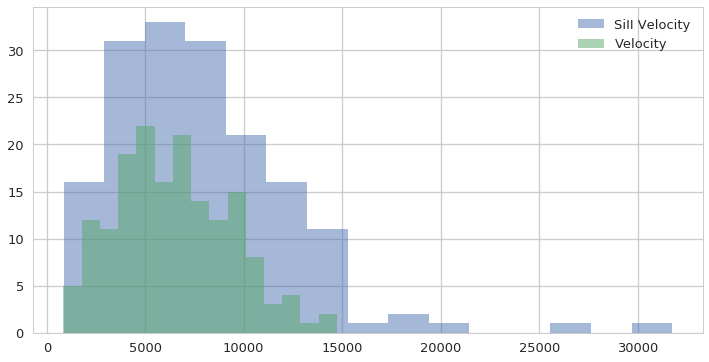

In [112]:
plt.hist(sn_data['v_siII'], alpha=0.5, label='SiII Velocity', bins=15)
plt.hist(sn_data['v'], alpha=0.5, label='Velocity', bins=15)
plt.legend()

In [113]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=2, covariance_type='spherical')
clf.fit(sn_data['v_siII'][:,np.newaxis])

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=2, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [123]:
mu = clf.means_
cov = clf.covariances_.reshape(2)

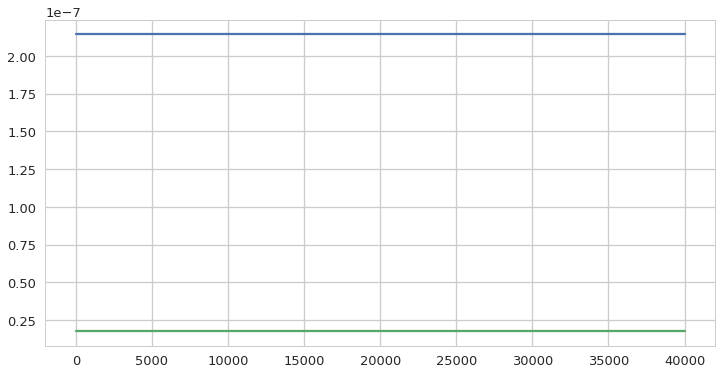

In [125]:
x = np.linspace(0,4e4,1000)
plt.plot(x, norm.pdf(x, mu[0], cov[0])/p_lv)
plt.plot(x, norm.pdf(x, mu[1], cov[1])/p_hv)

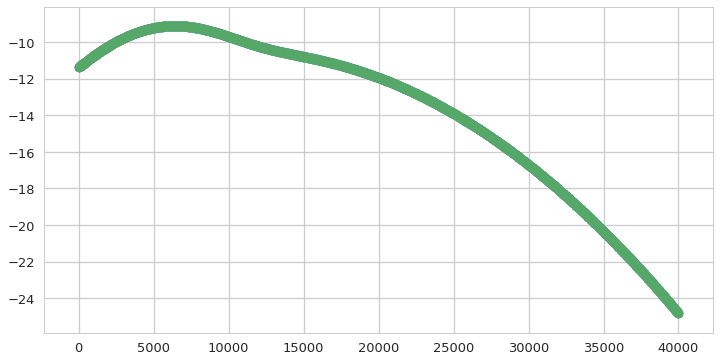

In [135]:
plt.scatter(x, clf.score_samples(x[:,np.newaxis]))
plt.scatter(x, clf.score_samples(x[:,np.newaxis]))

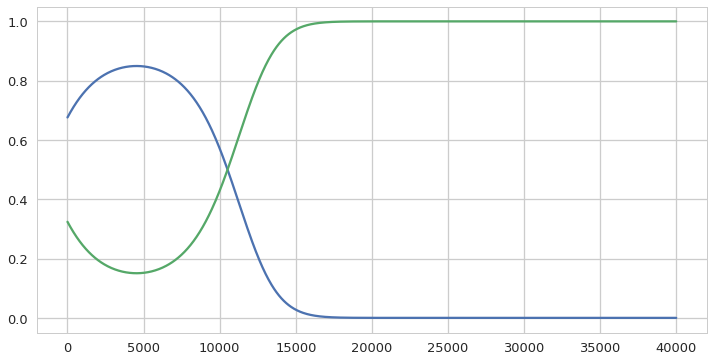

In [116]:
x = np.linspace(0,4e4,1000)
p = clf.predict_proba(x[:,np.newaxis])
plt.plot(x, p[:,0])
plt.plot(x, p[:,1])

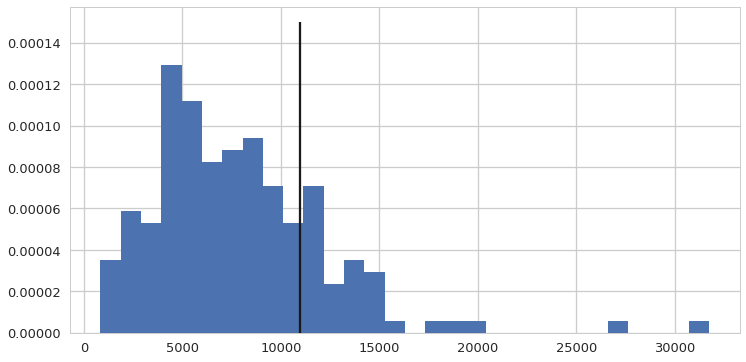

In [156]:
labels = clf.predict(sn_data['v_siII'][:,np.newaxis])
hv = sn_data['v_siII'].values[labels==1]
lv = sn_data['v_siII'].values[labels==0]

plt.hist(sn_data['v_siII'], label='SiII Velocity', density=True, bins=30)
plt.vlines(1.1e4, 0, 1.5e-4)
# plt.ylim(0,2e-4)

In [122]:
p_lv = len(lv) / sn_data.shape[0]
p_hv = len(hv) / sn_data.shape[0]

* MCMC
* KS Grid-search


* 2 or 3 parameters

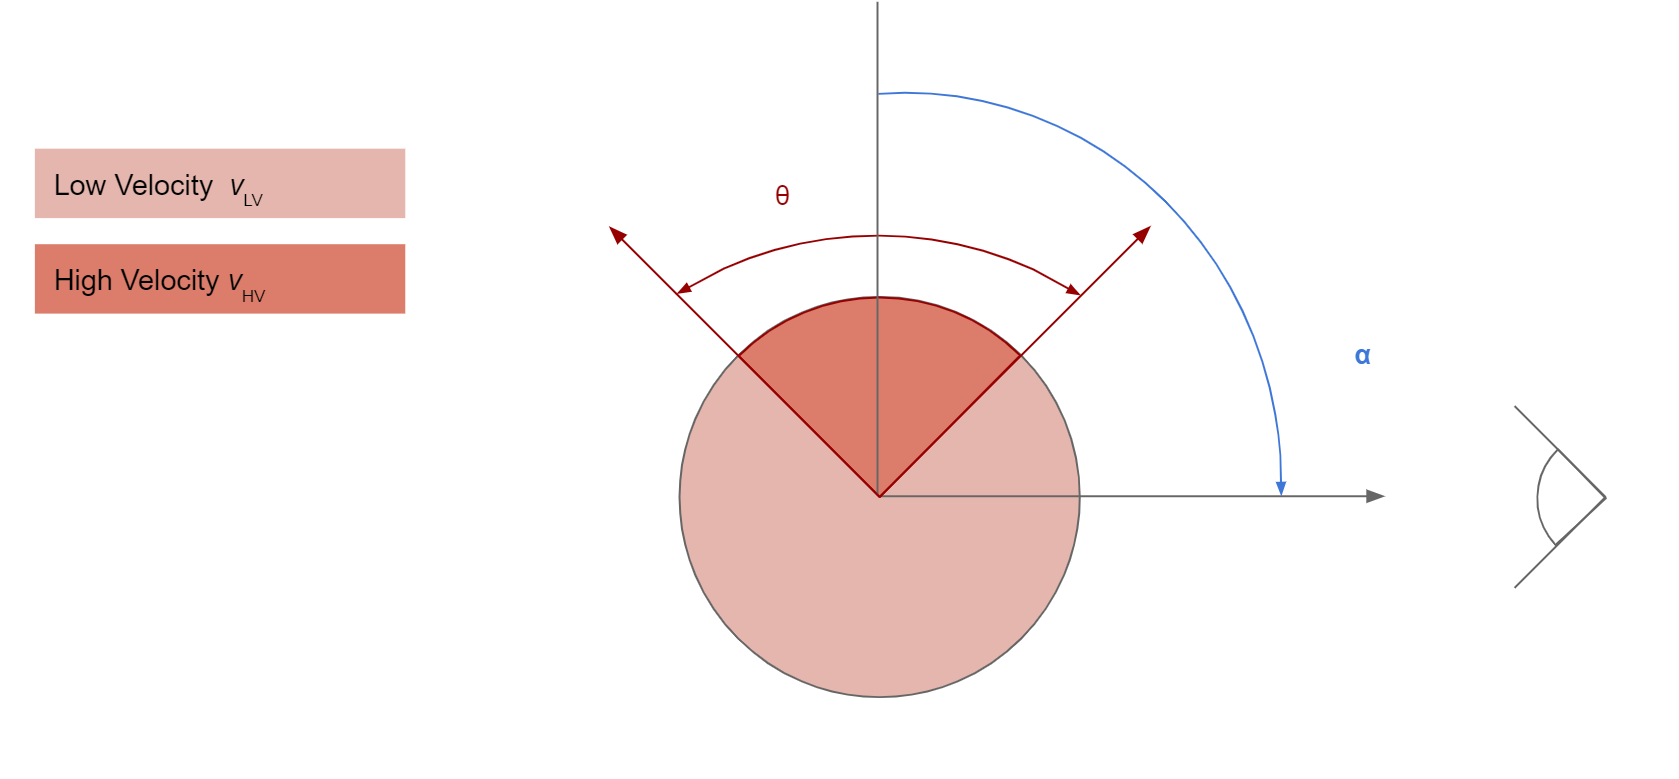

We can classify $D$ to high velocity SNe Ia (HV) and low velocity SNe Ia (LV) by some Bayes optimal rule.

$$
D = \begin{cases} \text{HV} & P(HV \mid D) > P(LV \mid D) \\ \text{LV} & \text{otherwise.} \end{cases}
$$

We wish to determine the posteriors of the parameters $w$ only using HV data,

$$
P(w \mid HV) \propto P(HV \mid w)P(w) 
$$

$$w = [\theta~,\quad \mu_\text{HV}~,\quad \mu_\text{LV}~,\quad \alpha]$$

Where

$$P(HV \mid w) = \prod P(HV \mid w_i)$$

## Semisphere Case

Assume $\theta = \pi$, then it must be that there's a 50% chance of observing the high velocity region as line of sight varies.

$$
P(HV \mid \theta=\pi) = 1/2
$$

The velocity observed is modeled by the sample.

$$
P(HV \mid \mu_\text{HV}) \mid \prod N(v,  )
$$